In [1]:
# python2 and python3 compatibility between loaded modules
from __future__ import print_function

In [2]:
# All imports go here
%matplotlib notebook

# Reading files
import os

# Vector manipulations
import numpy as np

# DL framework
# torch
import torch
from torch import nn
from torch.nn import functional as F
import torch.utils.data as td
import torchvision as tv
from torch.nn.utils.rnn import pack_padded_sequence

# Plotting images
from matplotlib import pyplot as plt

# COCO loading captions
from pycocotools.coco import COCO
import skimage.io as io
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

# import created vocabulary
from vocab_creator import VocabCreate as vc

# PIL Image
from PIL import Image

# regex for captions
import re

# import nntools
import nntools_modified as nt

# import add for fast addition between lists
from operator import add

from pycocoevalcap.bleu.bleu import Bleu
"""
# evaluation metrics on MSCOCO dataset
from pycocoevalcap.eval import COCOEvalCap
from pycocoevalcap.tokenizer.ptbtokenizer import PTBTokenizer

from pycocoevalcap.meteor.meteor import Meteor
from pycocoevalcap.rouge.rouge import Rouge
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.spice.spice import Spice
"""


# json for dumping stuff onto files as output
import json
from json import encoder
encoder.FLOAT_REPR = lambda o: format(o, '.3f')

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [4]:
# data loading
dataset_root_dir = '/datasets/COCO-2015/'
annotations_root_dir = '../datasets/COCO/annotations/'
train_dir = "train2014"
val_dir = "val2014"
test_dir = "test2015"

In [5]:
# training data annotations
train_ann = "{}captions_{}.json".format(annotations_root_dir, train_dir)
coco_train_caps = COCO(train_ann)

loading annotations into memory...
Done (t=0.60s)
creating index...
index created!


In [6]:
# validation data annotations
val_ann = "{}captions_{}.json".format(annotations_root_dir, val_dir)
coco_val_caps = COCO(val_ann)

loading annotations into memory...
Done (t=0.40s)
creating index...
index created!


In [7]:
# get all the image IDs
train_image_ids = coco_train_caps.getImgIds()
# loadImgs() returns all the images
train_imgs = coco_train_caps.loadImgs(train_image_ids)

In [8]:
print(type(train_imgs), len(train_imgs))

<class 'list'> 82783


In [9]:
# get all the val image ids
val_image_ids = coco_val_caps.getImgIds()
# loadImgs() returns all the images
val_imgs = coco_val_caps.loadImgs(val_image_ids)

In [10]:
# read 1 random training image from file 
rand_id = np.random.randint(0, len(train_imgs))
rand_img = io.imread('{}/{}/{}'.format(dataset_root_dir, train_dir, train_imgs[rand_id]['file_name']))

In [11]:
plt.axis('off')
plt.imshow(rand_img)
plt.show()

<IPython.core.display.Javascript object>

In [12]:
# load caption for this particular image
ann_id = coco_train_caps.getAnnIds(imgIds=train_imgs[rand_id]['id'])
anns = coco_train_caps.loadAnns(ann_id)
coco_train_caps.showAnns(anns)
f = plt.figure()
plt.imshow(rand_img)
plt.axis("off")
plt.show()

The under side of a white airplane flying in the sky.
A large commercial jet flying overhead against the blue backdrop.
A large jetliner flying through a lovely blue sky.
Silver jet flying upward in the blue sky.
A large commercial airplane flying in the sky above


<IPython.core.display.Javascript object>

In [13]:
print(anns)
print(len(anns))
print(anns[0])
print(anns[0]['caption'])

[{'image_id': 395495, 'id': 59592, 'caption': 'The under side of a white airplane flying in the sky.'}, {'image_id': 395495, 'id': 66531, 'caption': 'A large commercial jet flying overhead against the blue backdrop.'}, {'image_id': 395495, 'id': 69978, 'caption': 'A large jetliner flying through a lovely blue sky.'}, {'image_id': 395495, 'id': 70530, 'caption': 'Silver jet flying upward in the blue sky.'}, {'image_id': 395495, 'id': 72819, 'caption': 'A large commercial airplane flying in the sky above'}]
5
{'image_id': 395495, 'id': 59592, 'caption': 'The under side of a white airplane flying in the sky.'}
The under side of a white airplane flying in the sky.


In [14]:
# read 1 random testing image from file
val_rand_id = np.random.randint(0, len(val_imgs))
val_rand_img = io.imread('{}/{}/{}'.format(dataset_root_dir, val_dir, val_imgs[val_rand_id]['file_name']))

In [15]:
plt.axis('off')
plt.imshow(val_rand_img)
plt.show()

In [16]:
# load caption for this particular image
ann_id = coco_val_caps.getAnnIds(imgIds=val_imgs[val_rand_id]['id'])
anns = coco_val_caps.loadAnns(ann_id)
coco_val_caps.showAnns(anns)
f = plt.figure()
plt.imshow(val_rand_img)
plt.axis("off")
plt.show()

A street sign on top of two one way arrow signs.
A light pole has four street signs at an intersection.
A street pole is loaded with different signs.
a group of street signs on a pole next to some trees
Several street signs hand on a pole as a brick building stands in the back ground near some trees.


<IPython.core.display.Javascript object>

In [17]:
# dataset class
class COCODataset(td.Dataset):
    
    
    def __init__(self, dataset_root_dir, annotations_root_dir, vocab, mode="train2014", image_size=(224, 224)):
        super(COCODataset, self).__init__()
        self.dataset_root_dir = dataset_root_dir
        self.annotations_root_dir = annotations_root_dir
        self.image_size = image_size
        self.mode = mode
        # training data annotations
        self.ann = "{}captions_{}.json".format(annotations_root_dir, mode)
        self.coco_caps = COCO(self.ann)
        # get all the image IDs
        self.image_ids = self.coco_caps.getImgIds()
        self.ann_ids = list(self.coco_caps.anns.keys())
        # loadImgs() returns all the images
        self.imgs = self.coco_caps.loadImgs(self.image_ids)
        self.vocab = vocab
        
    def __len__(self):
        return len(self.ann_ids)
    
    def __repr__(self):
        return "COCODataset(mode={}, image_size={})". \
        format(self.mode, self.image_size)
    
    def __getitem__(self, idx):
        ann_id = self.ann_ids[idx]
        cap = self.coco_caps.anns[ann_id]["caption"]
        img_id = self.coco_caps.anns[ann_id]["image_id"]
        img_path = self.coco_caps.loadImgs(img_id)[0]["file_name"]
        
        img = Image.open('{}/{}/{}'.format(self.dataset_root_dir, self.mode, img_path))
        img = img.convert('RGB')
        transform = tv.transforms.Compose([
            tv.transforms.Resize(self.image_size),
            #tv.transforms.RandomHorizontalFlip(),
            tv.transforms.ToTensor(),
            tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        x = transform(img)
        
        # return caption
        cap = str(cap)
        clean_cap = re.sub(r'[^a-zA-Z0-9 ]+', '', cap)
        word_list = clean_cap.lower().strip().split()
        for i in range(len(word_list)):
            if word_list[i] not in vocab.one_hot_inds:
                word_list[i]="unk_vec"
        d = torch.Tensor([vocab.one_hot_inds["start_vec"]]
                               + [vocab.one_hot_inds[w] for w in word_list]
                               + [vocab.one_hot_inds["end_vec"]]
        )
        return x, d
    

In [18]:
# load the vocabulary
# or Create and save to output
dict_path = "../outputs/vocab.npz"
vocab = vc(train_ann, dict_path)

In [19]:
print(len(vocab))

8844


In [20]:
# create an instance of the cocodataset
training_dataset = COCODataset(dataset_root_dir, annotations_root_dir, vocab)

loading annotations into memory...
Done (t=0.66s)
creating index...
index created!


In [21]:
def myimshow(image, ax=plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image<0] = 0
    image[image>1] = 1
    h = ax.imshow(image)
    ax.axis('off')
    return h

In [22]:
img, cap = training_dataset.__getitem__(47)
print(cap)
myimshow(img)

tensor([8.8410e+03, 2.0200e+02, 2.0300e+02, 1.2400e+02, 2.0400e+02, 2.0500e+02,
        7.4000e+01, 7.5000e+01, 1.0000e+00, 2.0600e+02, 2.0700e+02, 8.8420e+03])


In [23]:
cap = cap.numpy().astype(int)
print(cap, cap.dtype)
print(type(list(cap)))
captions = [vocab.dict[cap[c]] for c in range(len(cap))]

[8841  202  203  124  204  205   74   75    1  206  207 8842] int64
<class 'list'>


In [24]:
for c in range(len(cap)):
    print(cap[c], type(cap[c]))
    print(vocab.dict[cap[c]])

8841 <class 'numpy.int64'>
start_vec
202 <class 'numpy.int64'>
seagulls
203 <class 'numpy.int64'>
flying
124 <class 'numpy.int64'>
overhead
204 <class 'numpy.int64'>
while
205 <class 'numpy.int64'>
trucks
74 <class 'numpy.int64'>
sit
75 <class 'numpy.int64'>
in
1 <class 'numpy.int64'>
a
206 <class 'numpy.int64'>
parking
207 <class 'numpy.int64'>
lot
8842 <class 'numpy.int64'>
end_vec


In [25]:
print(" ".join(captions))

start_vec seagulls flying overhead while trucks sit in a parking lot end_vec


In [26]:
cap = "hellconvention"
clean_cap = re.sub(r'[^a-zA-Z0-9 ]+', '', cap)
word_list = clean_cap.lower().strip().split()
for i in range(len(word_list)):
    if word_list[i] not in vocab.one_hot_inds:
        word_list[i]="unk_vec"

print(word_list)

['unk_vec']


In [27]:
# defining the dataloader to be used
# collate_fn - to pad all the vectors to the same length
def collate_function(data):
    data.sort(key=lambda x:len(x[1]), reverse=True)
    img, cap=zip(*data)

    #stack images
    img = torch.stack(img, 0)

    #concatenate all captions
    cap_lens = [len(c) for c in cap]
    max_cap_lens = max(cap_lens)
    cap_lens = torch.Tensor(cap_lens)

    #pad all captions to max caption length
    padded_caption = torch.zeros(len(cap),max_cap_lens).long()
    for i, c in enumerate(cap):
        c_len = int(cap_lens[i].item())
        padded_caption[i,:c_len] = c[:c_len]

    return img, padded_caption, cap_lens

In [28]:
train_loader = td.DataLoader(training_dataset, batch_size=128, shuffle=True, pin_memory=True,
                             collate_fn=collate_function, worker_init_fn=torch.manual_seed(7))

In [29]:
print(type(train_loader), len(train_loader))

<class 'torch.utils.data.dataloader.DataLoader'> 3236


In [30]:
# index to caption
def index_to_cap(labs):
    """Index to caption"""
    cap = labs.cpu().data.numpy().astype(int)
    caps = [vocab.dict[cap[c]] for c in range(len(cap))]
    caps = caps[1:-1]
    caption = " ".join(caps)
    return caption

In [31]:
# # Display 1st image and label pair for the 1st 4 minibatches
# fig, axes = plt.subplots(ncols=2)
# fig.suptitle("1st image for 1st 2 minibatches")

# for bind, mbat in enumerate(train_loader):
#     # print(len(mbat))
#     # print(type(mbat[0]), type(mbat[1]))
#     # print(mbat[0].size(), mbat[1].size())
    
#     # The dataloader returns both the image and the caption
#     # image is in the 0th index, caption is 1st index
#     img = mbat[0][0, :, :, :]
#     lab = mbat[1][0]
#     capt = index_to_cap(lab)
#     # print(lab.item())
#     myimshow(img, ax=axes[bind])
#     #axes[bind].text(50, 250, "label: {}".format(caption), size=12, verticalalignment='center')
#     # axes[bind].set_ylabel("label: {}".format(lab.item()))
#     axes[bind].set_title("mini-batch {}".format(bind+1))
#     print(capt)
#     if bind == 1:
#         break

In [32]:
# validation dataset
val_dataset = COCODataset(dataset_root_dir, annotations_root_dir, vocab, mode=val_dir)

loading annotations into memory...
Done (t=0.33s)
creating index...
index created!


In [33]:
val_loader = td.DataLoader(val_dataset, batch_size=128, shuffle=False, pin_memory=True, collate_fn=collate_function)

In [34]:
# NN classifier from nntools
class NNClassifier(nt.NeuralNetwork):
    
    def __init__(self):
        super(NNClassifier, self).__init__()
        self.cross_entropy = nn.CrossEntropyLoss()
        
    def criterion(self, y, d):
        return self.cross_entropy(y, d)

In [35]:
vgg = tv.models.vgg16_bn(pretrained=True)
# print the network
print(vgg)

# print the named parameters of the network
for name, param in vgg.named_parameters():
    print(name, param.size(), param.requires_grad)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [36]:
class CNN_RNN(NNClassifier):
    
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1,
                 num_classes=512, fine_tuning=False):
        super(CNN_RNN, self).__init__()
        vgg = tv.models.vgg16_bn(pretrained=True)
        for param in vgg.parameters():
            param.requires_grad = fine_tuning
        self.features = vgg.features
        # the average pooling is the same
        self.avgpool = vgg.avgpool
        # the classifier is also the same
        self.classifier = vgg.classifier
        # CODE to change the final classifier layer
        num_ftrs = vgg.classifier[6].in_features
        self.classifier[6] = nn.Linear(num_ftrs, num_classes)
        
        # RNN Part
        self.embeddings = nn.Embedding(vocab_size, embed_size)
        self.unit = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, x, caps, lens):
        # COMPLETE the forward prop
        f = self.features(x)
        f = self.avgpool(f)
        f = torch.flatten(f, 1)
        f = self.classifier(f)
        
        # RNN forward prop
        embeddings = self.embeddings(caps)
        inputs = torch.cat((f.unsqueeze(1), embeddings), 1)
        packed_ip = pack_padded_sequence(inputs, lens, batch_first=True)
        
        h_state, _ = self.unit(packed_ip)
        outputs = self.linear(h_state[0])
        return outputs
    
    def greedy_sample(self, feats, max_len=30):
        output_ids = []
        states = None
        inputs = feats.unsqueeze(1)

        for i in range(max_len):
            
            h_state, states = self.unit(inputs, states)
            outputs = self.linear(h_state.squeeze(1))
            predicted = outputs.max(1)[1]
            output_ids.append(predicted)
            inputs = self.embeddings(predicted)
            inputs = inputs.unsqueeze(1)
            
        output_ids = torch.stack(output_ids, 1)
        return output_ids.squeeze()

In [37]:
class CaptionStatsManager(nt.StatsManager):
    
    def __init__(self):
        super(CaptionStatsManager, self).__init__()
        
    def init(self):
        super(CaptionStatsManager, self).init()
        self.tokenized_true = {}
        self.tokenized_pred = {}
        self.scorer = Bleu(4)
        self.running_bleu_scores = [0 for _ in range(4)]
        
    def accumulate(self, loss, x, y, d):
        super(CaptionStatsManager, self).accumulate(loss, x, y, d)        
        self.tokenized_true[0] = []
        self.tokenized_pred[0] = []
        _, pred_cap_lab = torch.max(y, 1)
        true_cap_lab = d
        pred_cap = index_to_cap(pred_cap_lab)
        true_cap = index_to_cap(true_cap_lab)
        self.tokenized_true[0].append(true_cap)
        self.tokenized_pred[0].append(pred_cap)
        bleu_scores, _ = self.scorer.compute_score(self.tokenized_true, self.tokenized_pred)
        self.running_bleu_scores = list(map(add, self.running_bleu_scores, bleu_scores))
        
        
    def summarize(self):
        # this is the average loss when called
        loss = super(CaptionStatsManager, self).summarize()
        
        # this is the average accuracy percentage when called
        bleu_score = [ a / self.number_update for a in self.running_bleu_scores]
        return {'loss' : loss, 'bleu' : bleu_score}

In [60]:
def plot(exp, fig, axes):
    axes[0].clear()
    axes[1].clear()
    
#     print("In plot()")
#     print(len(exp.history))
#     print(exp.history)
#     print(exp.history[0])
#     print(exp.history[0]['loss'])
#     print(exp.history[0]['bleu'])
#     print(exp.history[0]['bleu'][3])
    #print(exp.epoch)
    
    # Plot the training loss over the epochs
    axes[0].plot([exp.history[k]['loss'] for k in range((exp.epoch[0] + 1)*(exp.epoch[1]))],
                label="training loss")
    
    # Plot the evaluation loss over the epochs
    #axes[0].plot([exp.history[k][1]['loss'] for k in range(exp.epoch)],
    #            color='orange', label="evaluation loss")
    
    # legend for the plot
    axes[0].legend()
    
    # xlabel and ylabel
    axes[0].set_xlabel("Number of Mini-batches")
    axes[0].set_ylabel("Loss")
    
    # Plot the training accuracy over the epochs
    axes[1].plot([exp.history[k]['bleu'][0] for k in range((exp.epoch[0] + 1)*(exp.epoch[1]))],
                label="training BLEU-1")
    axes[1].plot([exp.history[k]['bleu'][1] for k in range((exp.epoch[0] + 1)*(exp.epoch[1]))],
                label="training BLEU-2")
    axes[1].plot([exp.history[k]['bleu'][2] for k in range((exp.epoch[0] + 1)*(exp.epoch[1]))],
                label="training BLEU-3")
    axes[1].plot([exp.history[k]['bleu'][3] for k in range((exp.epoch[0] + 1)*(exp.epoch[1]))],
                label="training BLEU-4")
    
    # Plot the evaluation accuracy over the epochs
    #axes[1].plot([exp.history[k][1]['accuracy'] for k in range(exp.epoch)],
    #            color='orange', label="evaluation accuracy")
    
    # legend for the plot
    axes[1].legend()
    
    # xlabel and ylabel
    axes[1].set_xlabel("Number of Minibatches")
    axes[1].set_ylabel("BLEU Scores")
    
    plt.tight_layout()
    
    # set the title for the figure
    # fig.suptitle("Loss and Accuracy metrics")
    fig.canvas.draw()

In [61]:
lr = 1e-3
net = CNN_RNN(embed_size=512, hidden_size=512, vocab_size=len(vocab),
              num_layers=1, num_classes=512, fine_tuning=False)
net = net.to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = CaptionStatsManager()
exp1 = nt.Experiment(net, training_dataset, val_dataset, adam,
                     stats_manager, collate_func=collate_function, output_dir="../outputs/framework_test/")

<IPython.core.display.Javascript object>


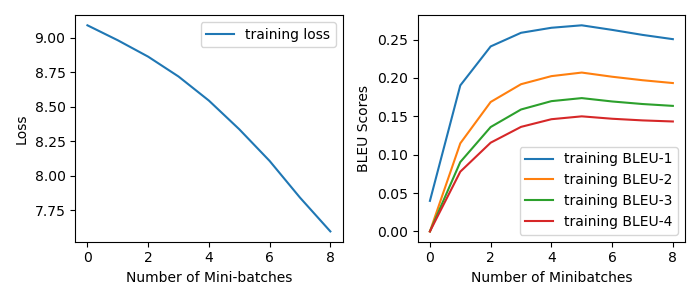

Start/Continue training from epoch 0
Epoch: 0  Batch: 0
Save stuff!
{'testlen': 1583, 'reflen': 1583, 'guess': [1583, 1582, 1581, 1580], 'correct': [63, 0, 0, 0]}
ratio: 0.9999999999993683
1
Saved!
Epoch: 0  Batch: 1
Save stuff!
{'testlen': 1553, 'reflen': 1553, 'guess': [1553, 1552, 1551, 1550], 'correct': [529, 240, 174, 154]}
ratio: 0.9999999999993561
2
Saved!
Epoch: 0  Batch: 2
Save stuff!
{'testlen': 1611, 'reflen': 1611, 'guess': [1611, 1610, 1609, 1608], 'correct': [552, 359, 247, 183]}
ratio: 0.9999999999993793
3
Saved!
Epoch: 0  Batch: 3
Save stuff!
{'testlen': 1564, 'reflen': 1564, 'guess': [1564, 1563, 1562, 1561], 'correct': [488, 342, 269, 204]}
ratio: 0.9999999999993606
4
Saved!
Epoch: 0  Batch: 4
Save stuff!
{'testlen': 1578, 'reflen': 1578, 'guess': [1578, 1577, 1576, 1575], 'correct': [460, 323, 256, 195]}
ratio: 0.9999999999993663
5
Saved!
Epoch: 0  Batch: 5
Save stuff!
{'testlen': 1553, 'reflen': 1553, 'guess': [1553, 1552, 1551, 1550], 'correct': [442, 289, 212, 173

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(7, 3))
exp1.run(num_epochs=1, plot=lambda exp: plot(exp, fig=fig, axes=axes))

In [ ]:
exp1_val = exp1.evaluate()
print(exp1_val)